# Train and Tune the Models

In [1]:
import os

import optuna

from src.config import Config
from src.data import time_series_split
from src.models.classical import LinearElasticNet
from src.preprocessing import get_preprocessor
from src.train import ModelTrainer
from src.utils import load_csv, set_seed

In [2]:
cfg = Config("../config/config.yaml")
rng = set_seed(cfg.runtime.seed)

In [3]:
df_full = load_csv(str(os.path.join(cfg.data.processed_dir, cfg.data.name_features_full)))
df_ml = df_full.drop(columns=["open", "high", "low", "close", "volume", "adj_close"]).copy()
df_ml

,date,pos,neu,neg,pos_minus_neg,emb_0,emb_1,emb_2,emb_3,emb_4,...,sma_25,ema_25,lag_50,sma_50,ema_50,quarter,dow,q_mean,q_std,q_skew
0,2008-10-21,0.737096,0.076694,0.186210,0.550886,-0.462686,-0.152562,-0.743356,0.615262,0.356628,...,-0.008092,-0.006275,0.004085,-0.005313,-0.004990,4,1,0.000434,0.016386,0.204187
1,2008-10-22,0.677890,0.081199,0.240911,0.436979,-0.389234,-0.237015,-0.742020,0.620925,0.304372,...,-0.008778,-0.010302,-0.011943,-0.006247,-0.007094,4,2,0.000434,0.016386,0.204187
2,2008-10-23,0.622471,0.138790,0.238739,0.383732,-0.534321,-0.204868,-0.805277,0.724014,0.423209,...,-0.009495,-0.007972,-0.009451,-0.005658,-0.006031,4,3,0.000434,0.016386,0.204187
3,2008-10-24,0.421691,0.087317,0.490992,-0.069300,-0.483006,-0.212878,-0.541037,0.665995,0.307276,...,-0.012275,-0.010174,0.007168,-0.006533,-0.007230,4,4,0.000434,0.016386,0.204187
4,2008-10-27,0.636082,0.108867,0.255051,0.381030,-0.454167,-0.198045,-0.659666,0.594337,0.291405,...,-0.011926,-0.011279,0.003778,-0.007100,-0.007909,4,0,0.000434,0.016386,0.204187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,2016-06-27,0.684537,0.065429,0.250034,0.434503,-0.126545,-0.069503,-0.505809,0.675737,0.537852,...,-0.000833,-0.002734,-0.001617,-0.000865,-0.001261,2,0,0.000062,0.009649,-0.181613
1934,2016-06-28,0.714076,0.086932,0.198991,0.515085,-0.035628,0.026517,-0.447723,0.623409,0.638349,...,-0.000191,-0.001324,0.005944,-0.000671,-0.000600,2,1,0.000062,0.009649,-0.181613
1935,2016-06-29,0.673349,0.114712,0.211939,0.461410,-0.183834,-0.045571,-0.742004,0.678196,0.518598,...,-0.000026,0.000027,0.002742,-0.000402,0.000060,2,2,0.000062,0.009649,-0.181613
1936,2016-06-30,0.727080,0.040575,0.232345,0.494736,-0.142834,-0.103121,-0.675863,0.680667,0.464056,...,0.000175,0.001041,0.002361,-0.000185,0.000576,2,3,0.000062,0.009649,-0.181613


In [4]:
# train, test, forecast = split_train_test(df_ml, test_ratio=0.8, horizon=30)
train, val, test, forecast = time_series_split(df_ml, train_ratio=0.8, val_ratio=0.1, horizon=30)

In [5]:
X_train, y_train = train.drop(columns=["date", "target"]), train["target"]
X_val, y_val = val.drop(columns=["date", "target"]), val["target"]
X_test, y_test = test.drop(columns=["date", "target"]), test["target"]
X_forecast = forecast.drop(columns=["date", "target"])

In [ ]:
X_forecast

In [10]:
model = LinearElasticNet(horizon=30)
preprocessor = get_preprocessor(X_train)

trainer = ModelTrainer(
    model=model,
    name="linear_elasticnet",
    config={},
    preprocessor=preprocessor
)

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: trainer.objective(trial, X_train, y_train, n_splits=5), n_trials=30)

best_params = study.best_params
print("Best params:", best_params)

[I 2025-08-16 17:45:59,754] A new study created in memory with name: no-name-11d3ca73-f71b-4096-ad62-edc790c7f2bc
2025-08-16 17:45:59,755 - INFO - ModelTrainer - Running Optuna trial with params: {'alpha': 0.0812600130432228, 'l1_ratio': 0.4092240259018951}
2025-08-16 17:45:59,764 - INFO - LinearElasticNet - Starting model training...
2025-08-16 17:45:59,772 - INFO - LinearElasticNet - Starting model training...
2025-08-16 17:45:59,782 - INFO - LinearElasticNet - Starting model training...
2025-08-16 17:45:59,791 - INFO - LinearElasticNet - Starting model training...
2025-08-16 17:45:59,801 - INFO - LinearElasticNet - Starting model training...
[I 2025-08-16 17:45:59,804] Trial 0 finished with value: 0.008830439499552787 and parameters: {'alpha': 0.0812600130432228, 'l1_ratio': 0.4092240259018951}. Best is trial 0 with value: 0.008830439499552787.
2025-08-16 17:45:59,804 - INFO - ModelTrainer - Running Optuna trial with params: {'alpha': 0.0009487943419788045, 'l1_ratio': 0.60639403860

Best params: {'alpha': 0.0812600130432228, 'l1_ratio': 0.4092240259018951}


In [12]:
best_model = LinearElasticNet(horizon=30, **best_params)
trainer = ModelTrainer(best_model, name="linear_elasticne_best", config=best_params, preprocessor=preprocessor)
trainer.fit(X_train, y_train)

2025-08-16 17:46:28,290 - INFO - ModelTrainer - Starting model training...
2025-08-16 17:46:28,299 - INFO - LinearElasticNet - Starting model training...


In [13]:
eval_metrics = trainer.evaluate(X_test, y_test)
print(eval_metrics)

2025-08-16 17:46:34,361 - INFO - ModelTrainer - Evaluating model...


{'mae': 0.007253030005369097, 'mse': 9.114871290707546e-05, 'rmse': 0.009547183506515178, 'smape': 1.71689357437779, 'r2': -8.269946759509317e-05}


In [14]:
import optuna.visualization as vis


vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [15]:
trainer.save()
trainer.track_mlflow(eval_metrics)

2025-08-16 17:47:16,769 - INFO - ModelTrainer - Tracking run with MLflow.
2025/08/16 17:47:16 INFO mlflow.tracking.fluent: Experiment with name 'stock_forecasting' does not exist. Creating a new experiment.


In [16]:
import numpy as np


print("Target variance:", np.var(y_test))

Target variance: 9.114117558037897e-05


In [19]:
import pandas as pd
from matplotlib import pyplot as plt


def plot_forecast_from_predictions(
        full_df: pd.DataFrame,
        forecast_df: pd.DataFrame,
        predicted_returns: np.ndarray,
        price_col: str = "adj_close",
        forecast_col: str = "Forecasted Price",
        title: str = "Forecasted Prices vs Actual",
        zoom_days: int = 180,
        figsize=(14, 6)
):
    """
    Plot actual vs forecasted prices using predicted log returns from the model.

    Parameters:
    - full_df: The complete original DataFrame with prices.
    - forecast_df: The subset used for forecasting (e.g., last horizon days).
    - predicted_returns: Model's predicted log returns.
    - price_col: Column name with actual prices.
    - forecast_col: Name of column to store forecasted prices.
    - title: Plot title.
    - zoom_days: Days to show in the zoomed-in plot.
    - figsize: Size of the plot.
    """
    df = full_df.copy()
    forecast_idx = forecast_df.index

    # Get last known price
    last_price = df.loc[forecast_idx[0] - 1, price_col]

    # Convert log returns to prices
    predicted_prices = [last_price]
    for ret in predicted_returns:
        predicted_prices.append(predicted_prices[-1] * np.exp(ret))
    predicted_prices = predicted_prices[1:]

    # Add forecast to DataFrame
    df.loc[forecast_idx, forecast_col] = predicted_prices

    # Zoomed view
    zoom_start = max(df.index[-1] - zoom_days, 0)
    df_zoom = df.iloc[zoom_start:]

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(df_zoom[price_col], label="Actual Price", linewidth=2)
    plt.plot(df_zoom[forecast_col], label="Forecasted Price", linestyle="--", color="orange")
    plt.axvline(x=forecast_idx[0], color="gray", linestyle="--", label="Forecast Start")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


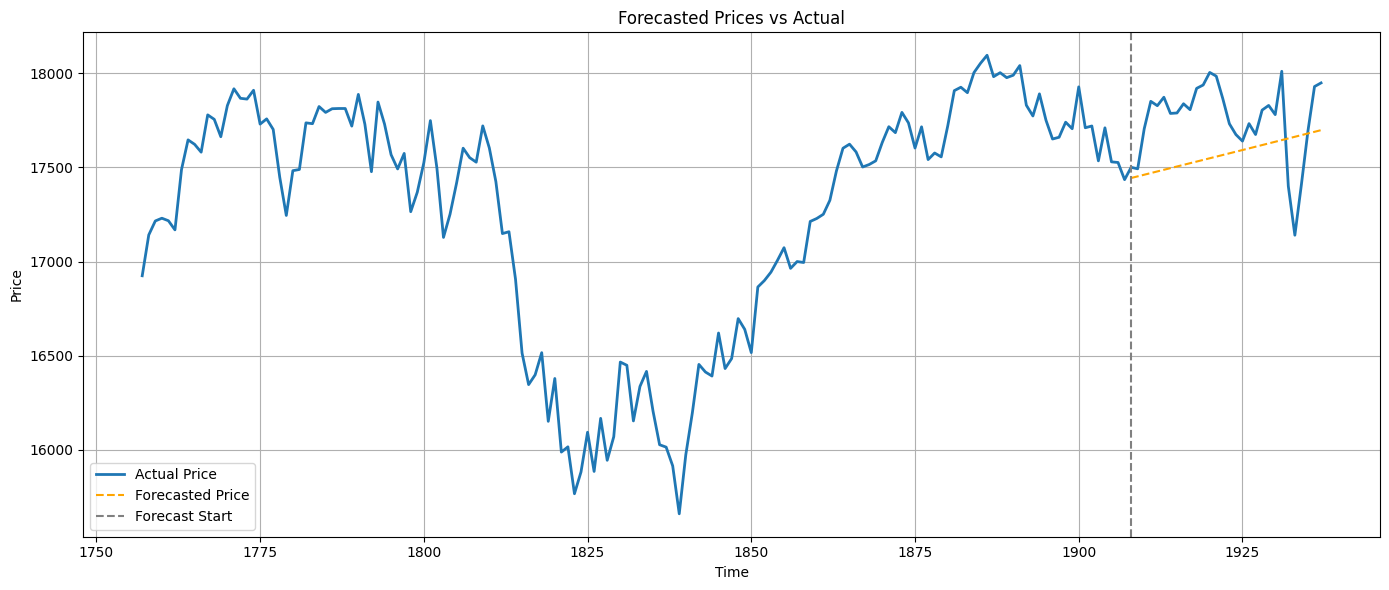

In [20]:
# Predict future returns
y_forecast_pred = trainer.predict(X_forecast)

# Plot
plot_forecast_from_predictions(
    full_df=df_full,              # full dataset with 'adj_close'
    forecast_df=forecast,        # forecast split
    predicted_returns=y_forecast_pred.ravel(),  # flatten if 2D
    price_col="adj_close",
    forecast_col="forecasted_price"
)